In [1]:
# Agentic AI News Editor: Comprehensive EDA Pipeline
# -----------------------------------------------
# This pipeline combines analysis of the Microsoft MIND dataset to prepare data
# for an agentic AI system that selects, ranks, and rewrites news headlines

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
from datetime import datetime
from collections import Counter
import re
import json
from textstat import flesch_reading_ease
import warnings
warnings.filterwarnings('ignore')

# Set visualization defaults
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Create output directory for results
output_dir = 'agentic_news_editor'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    os.makedirs(f'{output_dir}/plots')
    os.makedirs(f'{output_dir}/processed_data')

print("# Agentic AI News Editor - EDA Pipeline")
print("Starting EDA pipeline... Time:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print("-" * 80)

# Agentic AI News Editor - EDA Pipeline
Starting EDA pipeline... Time: 2025-05-07 14:29:53
--------------------------------------------------------------------------------


In [2]:
# ===============================================================
# PART 1: DATA LOADING AND INITIAL EXPLORATION
# ===============================================================
print("\n## PART 1: Data Loading and Initial Exploration")

# Load news data
news_cols = ["newsID", "category", "subcategory", "title", "abstract", "url", "title_entities", "abstract_entities"]
print("Loading news data...")
news_df = pd.read_csv("train_data/news.tsv", sep="\t", header=None, names=news_cols)
print(f"News data loaded: {news_df.shape[0]} rows, {news_df.shape[1]} columns")

# Loading behaviors data
print("Loading behaviors data...")
behaviors_cols = ["impression_id", "user_id", "time", "history", "impressions"]
behaviors_df = pd.read_csv("train_data/behaviors.tsv", sep="\t", header=None, names=behaviors_cols)
print(f"Behaviors data loaded: {behaviors_df.shape[0]} rows, {behaviors_df.shape[1]} columns")

# Store news_ids for reference
news_ids = set(news_df["newsID"])

# Sample display of news data
print("\nSample news data:")
print(news_df.head(3))

# Sample display of behaviors data
print("\nSample behaviors data:")
print(behaviors_df.head(3))


## PART 1: Data Loading and Initial Exploration
Loading news data...
News data loaded: 101527 rows, 8 columns
Loading behaviors data...
Behaviors data loaded: 2232748 rows, 5 columns

Sample news data:
   newsID   category               subcategory  \
0  N88753  lifestyle           lifestyleroyals   
1  N45436       news  newsscienceandtechnology   
2  N23144     health                weightloss   

                                               title  \
0  The Brands Queen Elizabeth, Prince Charles, an...   
1    Walmart Slashes Prices on Last-Generation iPads   
2                      50 Worst Habits For Belly Fat   

                                            abstract  \
0  Shop the notebooks, jackets, and more that the...   
1  Apple's new iPad releases bring big deals on l...   
2  These seemingly harmless habits are holding yo...   

                                             url  \
0  https://assets.msn.com/labs/mind/AAGH0ET.html   
1  https://assets.msn.com/labs/mind/AABmf2


## PART 2: News Content Analysis
Duplicate news IDs: 0
Duplicate news titles: 5367

Missing values in news data:
newsID                  0
category                0
subcategory             0
title                   0
abstract             5415
url                     0
title_entities          3
abstract_entities       6
dtype: int64
Percentage of abstracts missing: 5.33%

Very short titles (<10 chars): 0
Very short abstracts (<20 chars): 6035

Title reading ease score statistics:
count    101527.000000
mean         55.420589
std          25.118829
min        -809.390000
25%          40.350000
50%          57.430000
75%          73.170000
max         120.210000
Name: title_reading_ease, dtype: float64

Category distribution:
category
sports           32020
news             30478
finance           5916
travel            4955
lifestyle         4570
video             4569
foodanddrink      4418
weather           4255
autos             3071
health            2929
tv                1323
musi

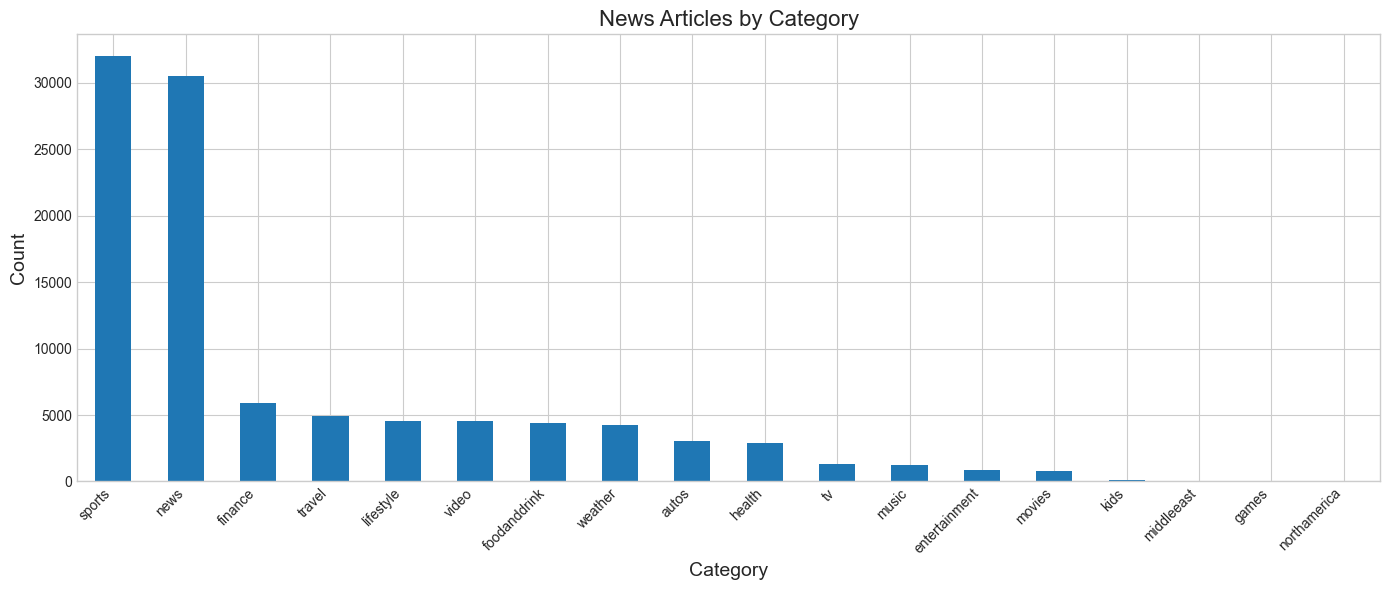

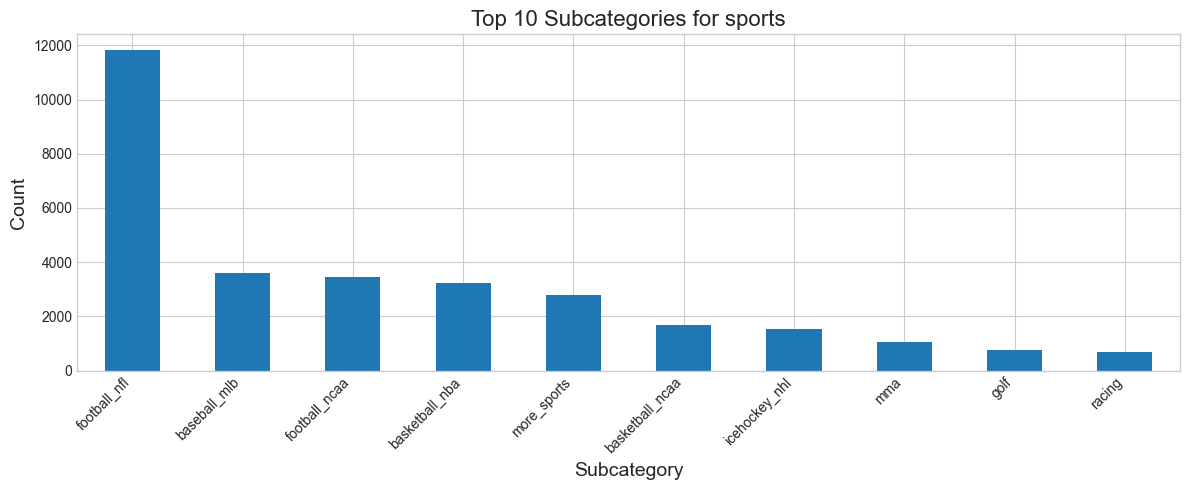

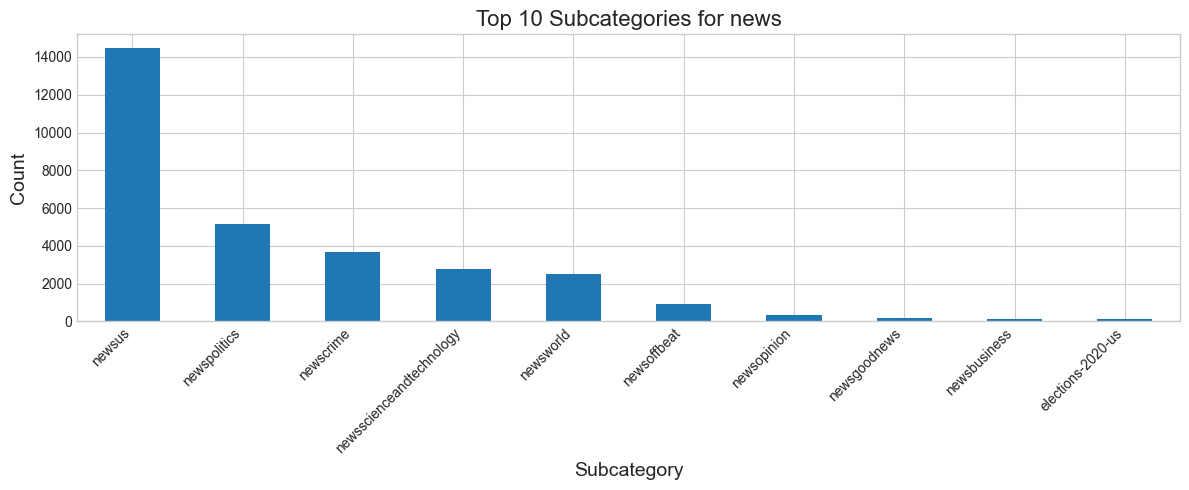

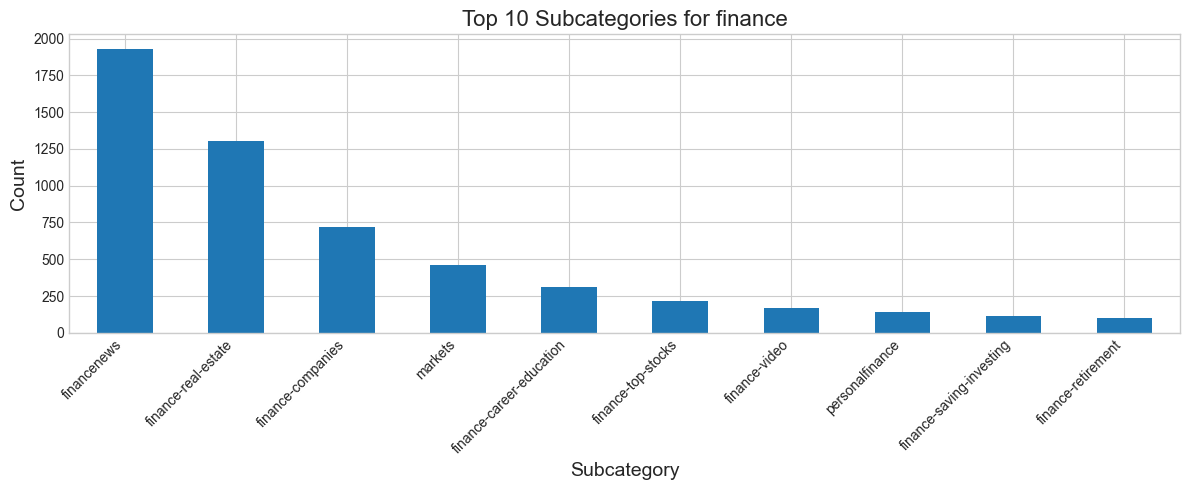

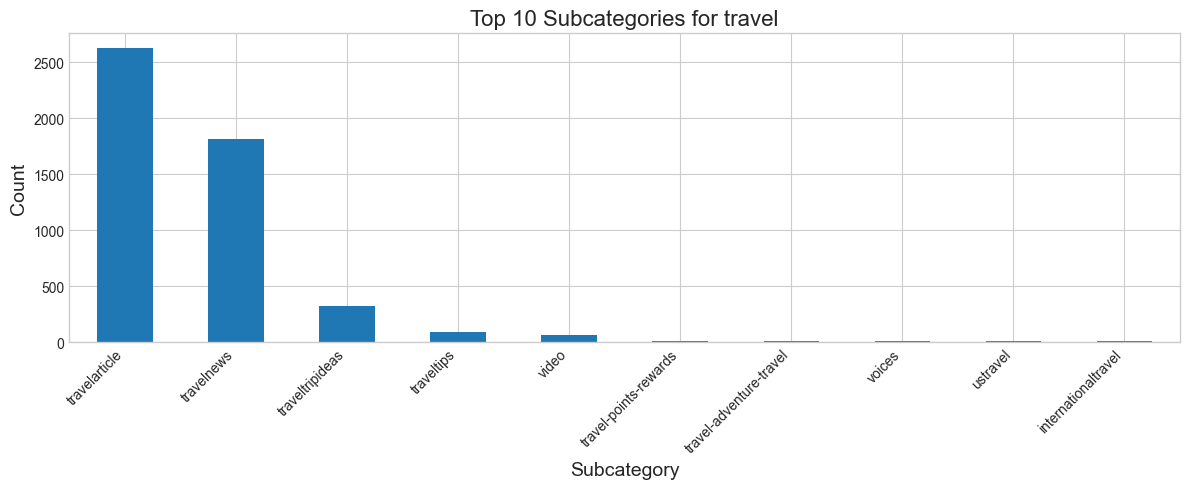

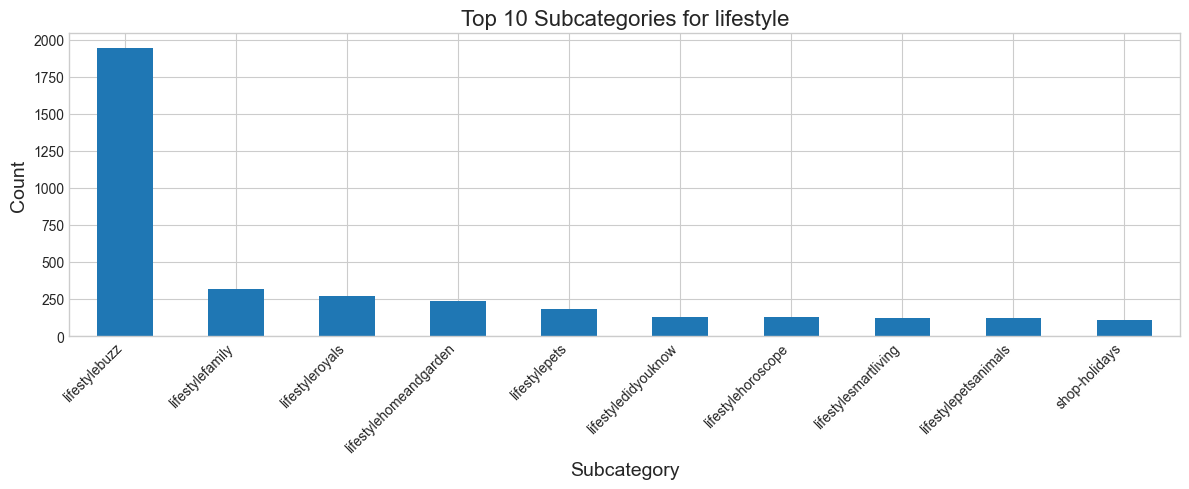

In [3]:
# ===============================================================
# PART 2: NEWS DATA ANALYSIS
# ===============================================================
print("\n## PART 2: News Content Analysis")

# Check for duplicates in news data
duplicate_news = news_df.duplicated(subset=["newsID"]).sum()
print(f"Duplicate news IDs: {duplicate_news}")

# Check for duplicate titles
duplicate_titles = news_df.duplicated(subset=["title"], keep=False).sum()
print(f"Duplicate news titles: {duplicate_titles}")

# Check missing values
print("\nMissing values in news data:")
print(news_df.isnull().sum())
print(f"Percentage of abstracts missing: {news_df['abstract'].isnull().mean()*100:.2f}%")

# Replace missing abstracts with empty string
news_df['abstract'] = news_df['abstract'].fillna("")
news_df['title_entities'] = news_df['title_entities'].fillna("[]")
news_df['abstract_entities'] = news_df['abstract_entities'].fillna("[]")

# Calculate text lengths for analysis
news_df["title_length"] = news_df["title"].str.len()
news_df["abstract_length"] = news_df["abstract"].str.len()

# Check title and abstract lengths
print(f"\nVery short titles (<10 chars): {(news_df['title_length'] < 10).sum()}")
print(f"Very short abstracts (<20 chars): {(news_df['abstract_length'] < 20).sum()}")

# Calculate reading ease scores for titles - key for headline rewriting task
def calculate_reading_scores(df):
    """Calculate reading ease scores for titles"""
    df['title_reading_ease'] = df['title'].apply(lambda x: flesch_reading_ease(x) if isinstance(x, str) and len(x) > 0 else np.nan)
    return df

news_df = calculate_reading_scores(news_df)

print("\nTitle reading ease score statistics:")
print(news_df['title_reading_ease'].describe())

# Analyze category and subcategory distributions
print("\nCategory distribution:")
category_counts = news_df["category"].value_counts()
print(category_counts)

# Create visualization of category distribution
plt.figure(figsize=(14, 6))
ax = category_counts.plot(kind='bar')
plt.title('News Articles by Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(f'{output_dir}/plots/category_distribution.png')

# Analyze subcategory distributions for top categories
top_categories = category_counts.index[:5].tolist()
for category in top_categories:
    subcat_counts = news_df[news_df['category'] == category]['subcategory'].value_counts().head(10)
    print(f"\nTop 10 subcategories for {category}:")
    print(subcat_counts)
    
    # Visualize subcategory distribution
    plt.figure(figsize=(12, 5))
    subcat_counts.plot(kind='bar')
    plt.title(f'Top 10 Subcategories for {category}', fontsize=16)
    plt.xlabel('Subcategory', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/plots/subcategory_{category}.png')


In [4]:
# ===============================================================
# PART 3: USER BEHAVIOR ANALYSIS
# ===============================================================
print("\n## PART 3: User Behavior Analysis")

# Check for duplicates and missing values in behaviors data
duplicate_impressions = behaviors_df.duplicated(subset=["impression_id"]).sum()
print(f"Duplicate impression IDs: {duplicate_impressions}")
print("\nMissing values in behaviors data:")
print(behaviors_df.isnull().sum())

# Calculate percentage of missing history data
missing_history_count = behaviors_df['history'].isna().sum()
missing_history_pct = (missing_history_count / len(behaviors_df)) * 100
print(f"Missing history: {missing_history_count} rows ({missing_history_pct:.2f}%)")

# Analyze users with missing history
missing_history_df = behaviors_df[behaviors_df['history'].isna()]
unique_users_missing = missing_history_df['user_id'].nunique()
print(f"Unique users with missing history: {unique_users_missing}")

# Process impressions data to analyze clicks and user engagement
print("\nProcessing impressions data...")

def process_impressions(df, sample_size=None):
    """Convert the impressions data into a flattened format for analysis"""
    if sample_size:
        df = df.head(sample_size)
    
    impressions_expanded = []
    
    for _, row in df.iterrows():
        try:
            impressions = row['impressions'].split()
            for item in impressions:
                if '-' in item:
                    news_id, clicked = item.split('-')
                    impressions_expanded.append({
                        'impression_id': row['impression_id'],
                        'user_id': row['user_id'],
                        'news_id': news_id,
                        'clicked': int(clicked)
                    })
        except Exception as e:
            print(f"Skipping row due to error: {e}")
            continue
    
    return pd.DataFrame(impressions_expanded)

# Process a sample of the behaviors data for quicker analysis
# For full dataset processing, remove the sample_size parameter
sample_size = 10000  # Adjust based on your computational resources
impressions_df = process_impressions(behaviors_df, sample_size=sample_size)
print(f"Expanded to {len(impressions_df)} impression records")

# Check for invalid news IDs (not in news_df)
invalid_news_ids = impressions_df[~impressions_df["news_id"].isin(news_ids)]
print(f"Impression records with invalid news IDs: {len(invalid_news_ids)}")

# Analyze overall click-through rate
clicks = impressions_df["clicked"].sum()
total = len(impressions_df)
print(f"\nOverall CTR: {clicks/total:.4f} ({clicks} clicks out of {total} impressions)")

# Analyze articles with very few impressions (potentially unreliable CTR)
article_impressions = impressions_df.groupby("news_id").size()
low_impression_articles = (article_impressions < 5).sum()
print(f"Articles with fewer than 5 impressions: {low_impression_articles}")

# Check for extreme CTRs (potential data issues)
article_ctrs = impressions_df.groupby("news_id")["clicked"].mean()
suspicious_ctrs = ((article_ctrs == 0) | (article_ctrs > 0.7)).sum()
print(f"Articles with suspicious CTRs (0 or >70%): {suspicious_ctrs}")


## PART 3: User Behavior Analysis
Duplicate impression IDs: 0

Missing values in behaviors data:
impression_id        0
user_id              0
time                 0
history          46065
impressions          0
dtype: int64
Missing history: 46065 rows (2.06%)
Unique users with missing history: 12857

Processing impressions data...
Expanded to 371707 impression records
Impression records with invalid news IDs: 0

Overall CTR: 0.0410 (15247 clicks out of 371707 impressions)
Articles with fewer than 5 impressions: 5711
Articles with suspicious CTRs (0 or >70%): 7079



## PART 4: Analysis for Editorial Tasks

Analyzing click-through rates by news category...

CTR by category:
               ctr_mean   ctr_std  impression_count
category                                           
kids           0.181818  0.404520                11
music          0.063961  0.244691             17151
tv             0.062125  0.241390             15823
weather        0.051962  0.221970              5658
video          0.048604  0.215057              5802
sports         0.047189  0.212045             37827
news           0.043940  0.204963            100705
lifestyle      0.041795  0.200123             41560
health         0.036945  0.188631             19624
finance        0.036700  0.188026             36022
foodanddrink   0.030737  0.172609             23652
movies         0.029527  0.169289              8399
entertainment  0.028541  0.166517             22739
travel         0.026993  0.162067             19968
autos          0.025768  0.158447             16765
northa

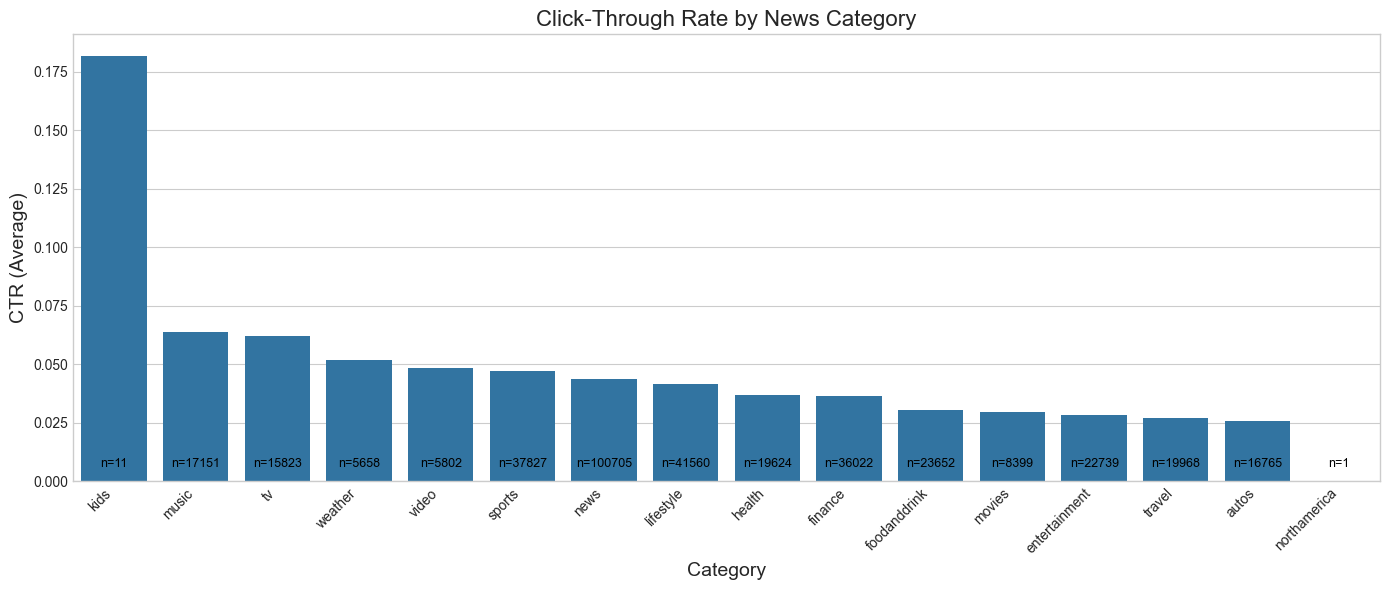

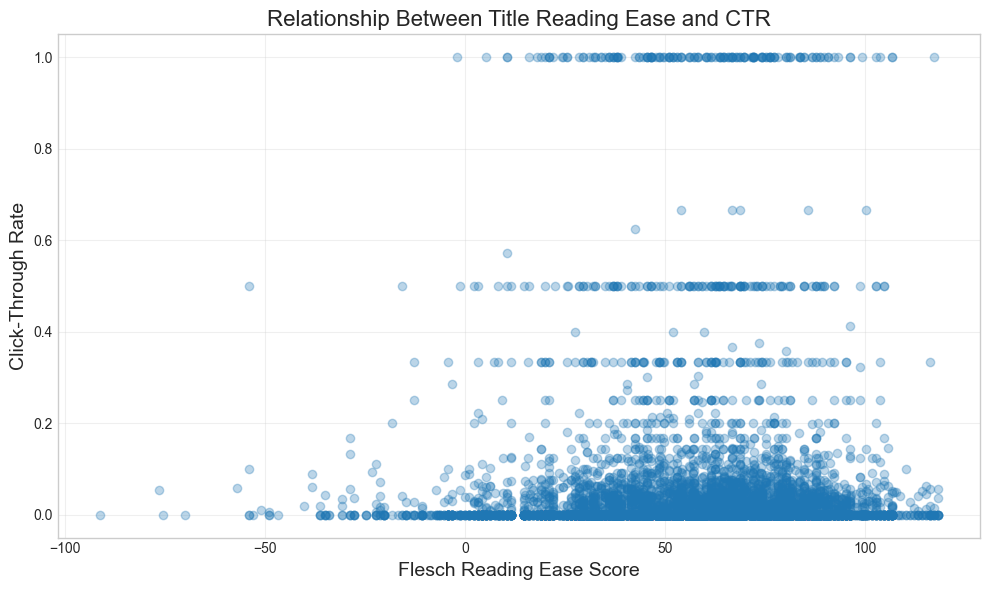

In [6]:
# ===============================================================
# PART 4: ANALYSIS RELEVANT TO EDITORIAL TASKS
# ===============================================================
print("\n## PART 4: Analysis for Editorial Tasks")

# Merge impressions with news data to analyze CTR by category
print("\nAnalyzing click-through rates by news category...")
merged_df = impressions_df.merge(
    news_df[['newsID', 'category', 'subcategory', 'title', 'title_reading_ease', 'title_length']], 
    left_on='news_id', 
    right_on='newsID'
)

# Calculate CTR by category
category_ctr = merged_df.groupby('category').agg({
    'clicked': ['mean', 'std', 'count']
})
category_ctr.columns = ['ctr_mean', 'ctr_std', 'impression_count']
category_ctr = category_ctr.sort_values('ctr_mean', ascending=False)

print("\nCTR by category:")
print(category_ctr)

# Visualize CTR by category
plt.figure(figsize=(14, 6))
ax = sns.barplot(x=category_ctr.index, y=category_ctr['ctr_mean'])
plt.title('Click-Through Rate by News Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('CTR (Average)', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Add count labels
for i, count in enumerate(category_ctr['impression_count']):
    ax.text(i, 0.005, f'n={count}', ha='center', va='bottom', color='black', fontsize=9)

plt.tight_layout()
plt.savefig(f'{output_dir}/plots/category_ctr.png')

# Statistical test for category CTR differences
categories = []
ctr_values = []
for category, group in merged_df.groupby('category'):
    if len(group) >= 30:  # Only include categories with sufficient data
        categories.append(category)
        ctr_values.append(group['clicked'].values)

if len(categories) >= 2:
    f_stat, p_value = stats.f_oneway(*ctr_values)
    print(f"\nANOVA test for CTR differences between categories:")
    print(f"F={f_stat:.4f}, p={p_value:.6f}")
    significance = "Significant" if p_value < 0.05 else "Not significant"
    print(f"Result: {significance} differences in CTR across categories")

# Analyze correlation between title properties and CTR
print("\nAnalyzing relationship between title properties and engagement...")

# Group by news_id to get average CTR per article
article_stats = merged_df.groupby('newsID').agg({
    'clicked': 'mean',
    'title_length': 'first',
    'title_reading_ease': 'first'
}).rename(columns={'clicked': 'ctr'})

# Calculate correlations
correlations = article_stats[['ctr', 'title_length', 'title_reading_ease']].corr()
print("\nCorrelations between article properties and CTR:")
print(correlations['ctr'].sort_values(ascending=False))

# Visualize relationship between reading ease and CTR
plt.figure(figsize=(10, 6))
plt.scatter(article_stats['title_reading_ease'], article_stats['ctr'], alpha=0.3)
plt.title('Relationship Between Title Reading Ease and CTR', fontsize=16)
plt.xlabel('Flesch Reading Ease Score', fontsize=14)
plt.ylabel('Click-Through Rate', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{output_dir}/plots/reading_ease_vs_ctr.png')

# Analyze headline patterns - can help with rewriting task
print("\nAnalyzing headline patterns...")

# Function to detect headline patterns
def analyze_headline_patterns(titles):
    patterns = {
        'questions': 0,
        'numbers': 0,
        'quotes': 0,
        'colons': 0,
        'ellipsis': 0
    }
    
    for title in titles:
        if '?' in title:
            patterns['questions'] += 1
        if any(char.isdigit() for char in title):
            patterns['numbers'] += 1
        if '"' in title or "'" in title:
            patterns['quotes'] += 1
        if ':' in title:
            patterns['colons'] += 1
        if '...' in title:
            patterns['ellipsis'] += 1
    
    total = len(titles)
    return {k: (v, v/total*100) for k, v in patterns.items()}

headline_patterns = analyze_headline_patterns(news_df['title'])
print("\nHeadline patterns:")
for pattern, (count, percentage) in headline_patterns.items():
    print(f"{pattern}: {count} ({percentage:.2f}%)")

# Analyze headline patterns by engagement
high_ctr_articles = article_stats[article_stats['ctr'] > article_stats['ctr'].median()]
low_ctr_articles = article_stats[article_stats['ctr'] <= article_stats['ctr'].median()]

high_ctr_news_ids = high_ctr_articles.index.tolist()
low_ctr_news_ids = low_ctr_articles.index.tolist()

high_ctr_titles = news_df[news_df['newsID'].isin(high_ctr_news_ids)]['title']
low_ctr_titles = news_df[news_df['newsID'].isin(low_ctr_news_ids)]['title']

high_ctr_patterns = analyze_headline_patterns(high_ctr_titles)
low_ctr_patterns = analyze_headline_patterns(low_ctr_titles)

print("\nHeadline patterns in high-engagement articles:")
for pattern, (count, percentage) in high_ctr_patterns.items():
    print(f"{pattern}: {count} ({percentage:.2f}%)")

print("\nHeadline patterns in low-engagement articles:")
for pattern, (count, percentage) in low_ctr_patterns.items():
    print(f"{pattern}: {count} ({percentage:.2f}%)")

In [7]:
# ===============================================================
# PART 5: PREPARE DATA FOR THE AGENTIC NEWS EDITOR
# ===============================================================
print("\n## PART 5: Data Preparation for Agentic News Editor")

# 1. Clean and process news data
print("Preparing news data...")
news_df_cleaned = news_df.copy()

# Filter out articles with very short titles or abstracts
news_df_cleaned = news_df_cleaned[news_df_cleaned['title_length'] >= 10]
news_df_cleaned = news_df_cleaned[news_df_cleaned['abstract_length'] >= 20]

# Add reading ease score if not already added
if 'title_reading_ease' not in news_df_cleaned.columns:
    news_df_cleaned = calculate_reading_scores(news_df_cleaned)

# 2. Prepare behavior data
print("Preparing behavior data...")

# Add CTR data to news articles
article_ctr_data = impressions_df.groupby('news_id').agg({
    'clicked': ['sum', 'count']
})
article_ctr_data.columns = ['total_clicks', 'total_impressions']
article_ctr_data['ctr'] = article_ctr_data['total_clicks'] / article_ctr_data['total_impressions']

# Merge CTR data with news data
news_with_engagement = news_df_cleaned.merge(
    article_ctr_data.reset_index(),
    left_on='newsID',
    right_on='news_id',
    how='left'
)

# Fill missing engagement data with zeros
engagement_columns = ['total_clicks', 'total_impressions', 'ctr']
news_with_engagement[engagement_columns] = news_with_engagement[engagement_columns].fillna(0)

# 3. Create dataset for title rewriting task
print("Creating dataset for headline rewriting task...")

# Filter to articles with sufficient impressions for reliable CTR data
rewriting_candidates = news_with_engagement[news_with_engagement['total_impressions'] >= 5].copy()

# Group titles by reading ease score to identify good and bad examples
rewriting_candidates['reading_ease_bin'] = pd.qcut(
    rewriting_candidates['title_reading_ease'], 
    q=5, 
    labels=['Very Hard', 'Hard', 'Medium', 'Easy', 'Very Easy']
)

# Create a dataset to show examples from different readability levels
rewriting_examples = {}
for readability_level in rewriting_candidates['reading_ease_bin'].unique():
    group_df = rewriting_candidates[rewriting_candidates['reading_ease_bin'] == readability_level]
    
    # Get high and low CTR examples from this readability group
    high_ctr = group_df.nlargest(5, 'ctr')
    low_ctr = group_df.nsmallest(5, 'ctr')
    
    rewriting_examples[readability_level] = {
        'high_ctr': high_ctr[['newsID', 'title', 'category', 'ctr', 'title_reading_ease']].to_dict('records'),
        'low_ctr': low_ctr[['newsID', 'title', 'category', 'ctr', 'title_reading_ease']].to_dict('records')
    }

# 4. Save processed data for the news editor system
print("Saving processed data...")

# Save the cleaned news data with engagement metrics
news_with_engagement.to_csv(f'{output_dir}/processed_data/news_with_engagement.csv', index=False)

# Save headline rewriting examples dataset
with open(f'{output_dir}/processed_data/headline_rewriting_examples.json', 'w') as f:
    json.dump(rewriting_examples, f, indent=2)

# Save category and subcategory distributions for editorial diversity goals
category_distribution = news_df['category'].value_counts().to_dict()
with open(f'{output_dir}/processed_data/category_distribution.json', 'w') as f:
    json.dump(category_distribution, f, indent=2)

# Create an editorial guideline summary based on the analysis
category_ctr_summary = category_ctr.reset_index().to_dict('records')
headline_insights = {
    'reading_ease_correlation': correlations['ctr']['title_reading_ease'],
    'headline_patterns': {
        'high_engagement': high_ctr_patterns,
        'low_engagement': low_ctr_patterns
    }
}

editorial_guidelines = {
    'category_performance': category_ctr_summary,
    'headline_insights': headline_insights,
    'overall_ctr_benchmark': clicks/total
}

with open(f'{output_dir}/processed_data/editorial_guidelines.json', 'w') as f:
    json.dump(editorial_guidelines, f, indent=2)

print("-" * 80)
print(f"EDA Pipeline completed! Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Processed data saved to '{output_dir}/processed_data/'")
print(f"Visualizations saved to '{output_dir}/plots/'")
print(f"Ready for Agentic AI News Editor development!")


## PART 5: Data Preparation for Agentic News Editor
Preparing news data...
Preparing behavior data...
Creating dataset for headline rewriting task...
Saving processed data...
--------------------------------------------------------------------------------
EDA Pipeline completed! Time: 2025-05-07 14:47:49
Processed data saved to 'agentic_news_editor/processed_data/'
Visualizations saved to 'agentic_news_editor/plots/'
Ready for Agentic AI News Editor development!


### Analysis

Questions in headlines significantly reduce CTR (↓27.9%, p < 0.001) — best to avoid.

Numbers in headlines slightly reduce CTR (↓9.8%, p < 0.05) — use sparingly and only when truly meaningful.

Flesch Reading Ease Score shows no meaningful correlation with CTR — title readability (as measured here) doesn’t drive clicks.

News categories have a strong effect on CTR:

High CTR: kids, music, tv

Low CTR: autos, travel, northamerica

Headline patterns:

High CTR headlines slightly more often contain quotes or numbers.

Low CTR headlines slightly more often contain questions and colons — again reinforcing that questions may underperform.

Flesch Reading Ease Score
A score from ~0 to 100+ that measures how easy a text is to read.
Higher score → easier to read.
Score ~60–70 = 8th–9th grade level (standard online content).
Negative scores → likely errors or very dense content.
Formula considers average sentence length and average syllables per word.
In our data: Not predictive of CTR → readers may be more influenced by content topic and style than raw readability.

Prompt Guidelines for LLM-Generated Headlines to increase CTR

Use informative, clear titles without unnecessary complexity.
Favor straightforward declarative formats (not questions).
Match tone and content to high-performing categories (e.g., music, TV).
Consider including emotion, surprise, or curiosity (instead of lists or questions).

Avoid:
Starting with "Is", "What", "How" — question formats underperform.
Relying on "Top 5", "10 Ways", etc. unless it directly adds value.
Overcomplicated or overly “clever” phrasing (no CTR benefit).

Baseline Template:
Generate a short, compelling headline for a [news category] article. Avoid using questions or numbers. Aim for a tone that is clear, direct, and engaging.
Write a headline for an article in the [sports/music/TV] category. Keep it under 12 words, use plain language, and avoid questions. Use quotes or strong verbs to capture attention.
Sanitizing Existing Headlines:
Rewrite this headline to increase click-through rate:
"Is Climate Change Getting Worse in 2024?"
Avoid questions
Avoid numbers
Match tone to a general audience